<h1>Prepare Environment</h1>

In [1]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import time

<h1>Loading dataset</h1>

In [4]:
DATA_DIR = './CamVid/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# Lets look at data we have
"""
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
"""
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'])

image, mask = dataset[5] # get some sample

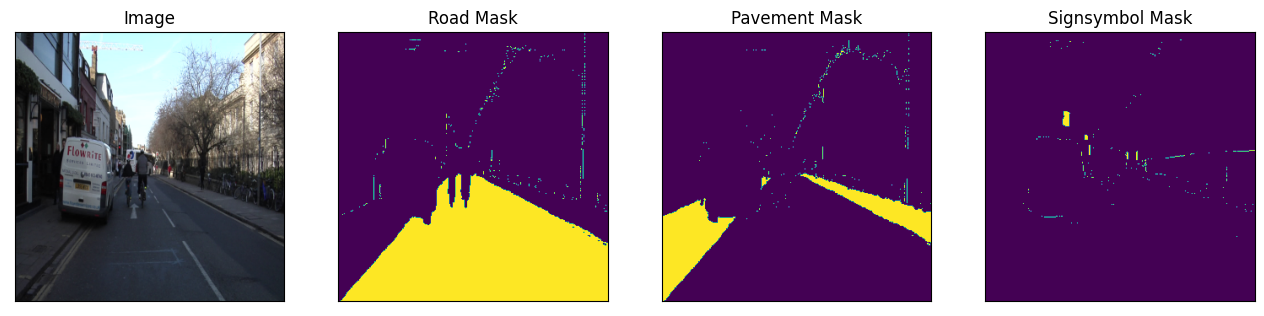

In [7]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

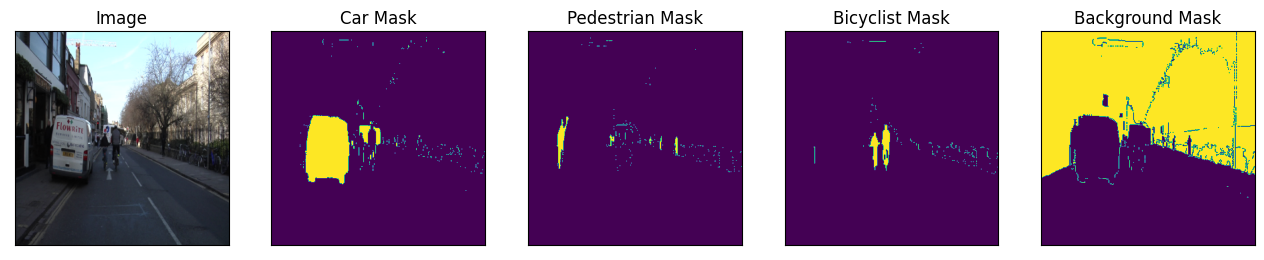

In [8]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Augmentation</h1>

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'], 
                  augmentation=get_training_augmentation())

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
image, mask = dataset[20] # get some sample

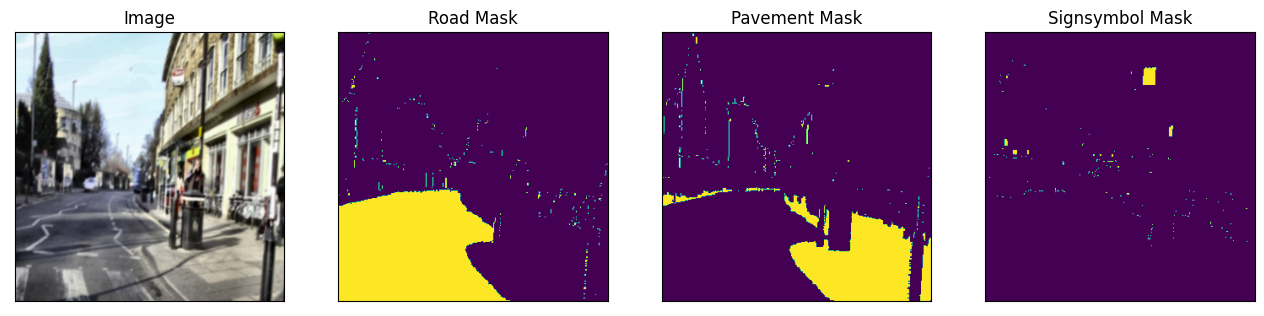

In [11]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

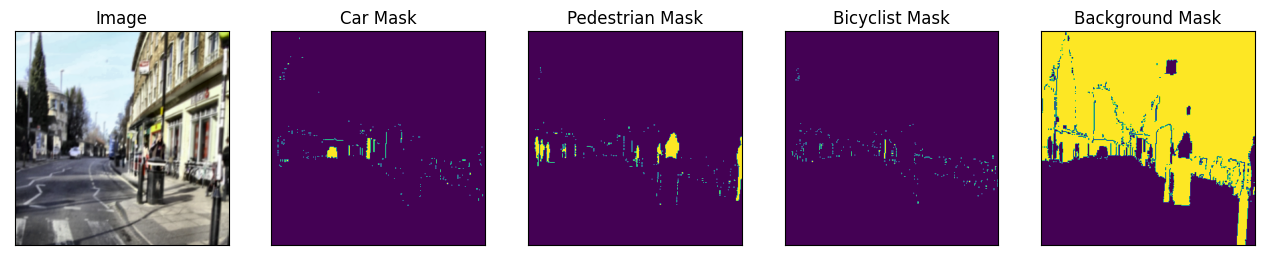

In [12]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Segmentation Model Training</h1>

In [13]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [14]:
BACKBONE = 'inceptionv3'
BATCH_SIZE = 4
CLASSES = ['road', 'pavement', 'signsymbol','car', 'pedestrian', 'bicyclist']
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [17]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2021-11-20 06:11:50.629878: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 13.55M (14213376 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-11-20 06:11:50.630372: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 13.55M (14213376 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-11-20 06:12:00.634396: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 13.55M (14213376 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-11-20 06:12:00.634911: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 13.55M (14213376 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-11-20 06:12:00.634933: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 300.0KiB (rounded to 307200)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_mallo

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [18]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

NameError: name 'model' is not defined

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [18]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/inceptionv3_Unet.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [20]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/tmp/ipykernel_25712/1794659408.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250


2021-11-20 02:40:08.190409: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


91/91 [==============================] - 41s 331ms/step - loss: 0.8328 - iou_score: 0.1500 - f1-score: 0.1950 - val_loss: 0.8451 - val_iou_score: 0.1419 - val_f1-score: 0.1790 - lr: 1.0000e-04
Epoch 2/250
91/91 [==============================] - 28s 311ms/step - loss: 0.6894 - iou_score: 0.3591 - f1-score: 0.4282 - val_loss: 0.6194 - val_iou_score: 0.3975 - val_f1-score: 0.4501 - lr: 1.0000e-04
Epoch 3/250
91/91 [==============================] - 29s 313ms/step - loss: 0.6252 - iou_score: 0.3982 - f1-score: 0.4600 - val_loss: 0.5700 - val_iou_score: 0.4043 - val_f1-score: 0.4600 - lr: 1.0000e-04
Epoch 4/250
91/91 [==============================] - 29s 313ms/step - loss: 0.5939 - iou_score: 0.4181 - f1-score: 0.4818 - val_loss: 0.5289 - val_iou_score: 0.4632 - val_f1-score: 0.5403 - lr: 1.0000e-04
Epoch 5/250
91/91 [==============================] - 29s 316ms/step - loss: 0.5664 - iou_score: 0.4475 - f1-score: 0.5175 - val_loss: 0.5038 - val_iou_score: 0.5042 - val_f1-score: 0.5915 - lr

Epoch 41/250
91/91 [==============================] - 29s 316ms/step - loss: 0.3668 - iou_score: 0.5905 - f1-score: 0.6830 - val_loss: 0.3043 - val_iou_score: 0.6439 - val_f1-score: 0.7457 - lr: 1.0000e-04
Epoch 42/250
91/91 [==============================] - 27s 299ms/step - loss: 0.3658 - iou_score: 0.5932 - f1-score: 0.6845 - val_loss: 0.3332 - val_iou_score: 0.6233 - val_f1-score: 0.7191 - lr: 1.0000e-04
Epoch 43/250
91/91 [==============================] - 27s 299ms/step - loss: 0.3605 - iou_score: 0.5955 - f1-score: 0.6858 - val_loss: 0.3303 - val_iou_score: 0.6258 - val_f1-score: 0.7277 - lr: 1.0000e-04
Epoch 44/250
91/91 [==============================] - 27s 300ms/step - loss: 0.3674 - iou_score: 0.5893 - f1-score: 0.6815 - val_loss: 0.3282 - val_iou_score: 0.6276 - val_f1-score: 0.7308 - lr: 1.0000e-04
Epoch 45/250
91/91 [==============================] - 27s 299ms/step - loss: 0.3538 - iou_score: 0.6025 - f1-score: 0.6948 - val_loss: 0.3394 - val_iou_score: 0.6214 - val_f1-s

<h1>Model Evaluation</h1>

In [21]:
print('Time training:{} (s)'.format(time_training))

Time training:3004.866466283798 (s)


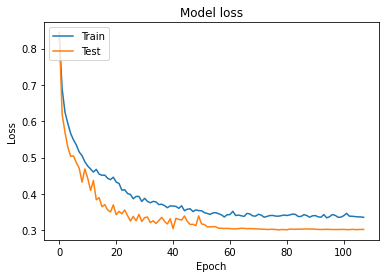

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

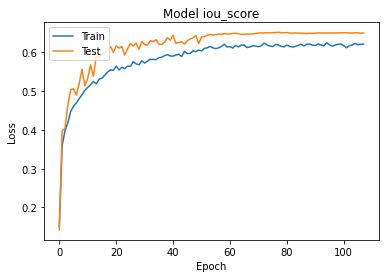

In [23]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [25]:
# load best weights
model.load_weights('./checkpoint/inceptionv3_Unet.h5')

In [26]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/tmp/ipykernel_25712/2477453485.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores  = model.evaluate_generator(test_dataloader)


Loss:0.42997
mean iou_score:0.53678
mean f1-score:0.61353


In [27]:
df = pd.DataFrame({'backbone':[BACKBONE],'model':['Unet'],'Time_training':[time_training],
                   'loss':[scores[0]],'Iou_score':[scores[1]]})

In [28]:
df

,backbone,model,Time_training,loss,Iou_score
0,inceptionv3,Unet,3004.866466,0.429969,0.536784


In [30]:
data = pd.read_excel('Evaluation_model.xlsx')
data = data[['backbone','model','Time_training','loss','Iou_score']]
data

,backbone,model,Time_training,loss,Iou_score
0,mobilenetv2,Unet,1879.674737,0.450194,0.519989
1,efficientnetb3,Unet,2729.571379,0.430244,0.534888


In [31]:
df = pd.concat([df,data],axis=0)
df

,backbone,model,Time_training,loss,Iou_score
0,inceptionv3,Unet,3004.866466,0.429969,0.536784
0,mobilenetv2,Unet,1879.674737,0.450194,0.519989
1,efficientnetb3,Unet,2729.571379,0.430244,0.534888


In [32]:
df.to_excel('Evaluation_model.xlsx')

<h1>Evaluation on Test</h1>

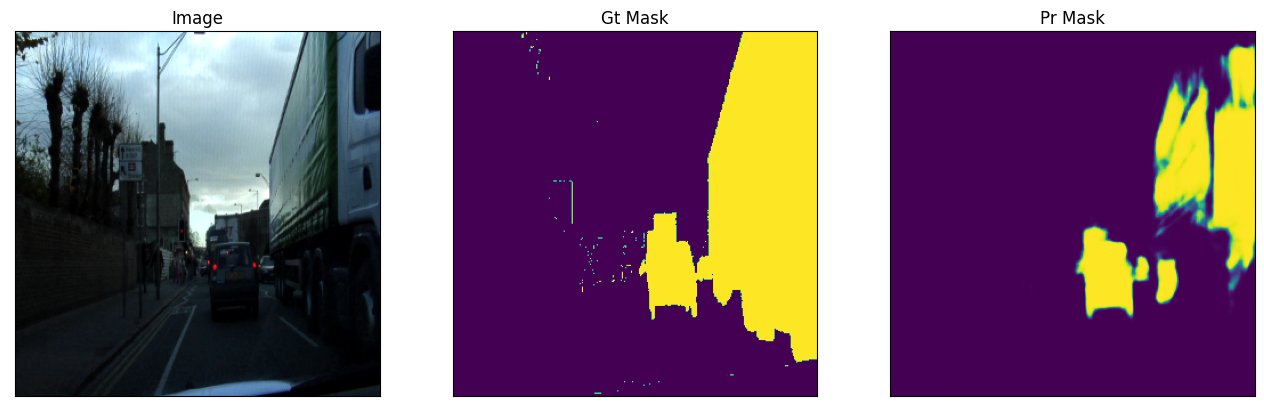

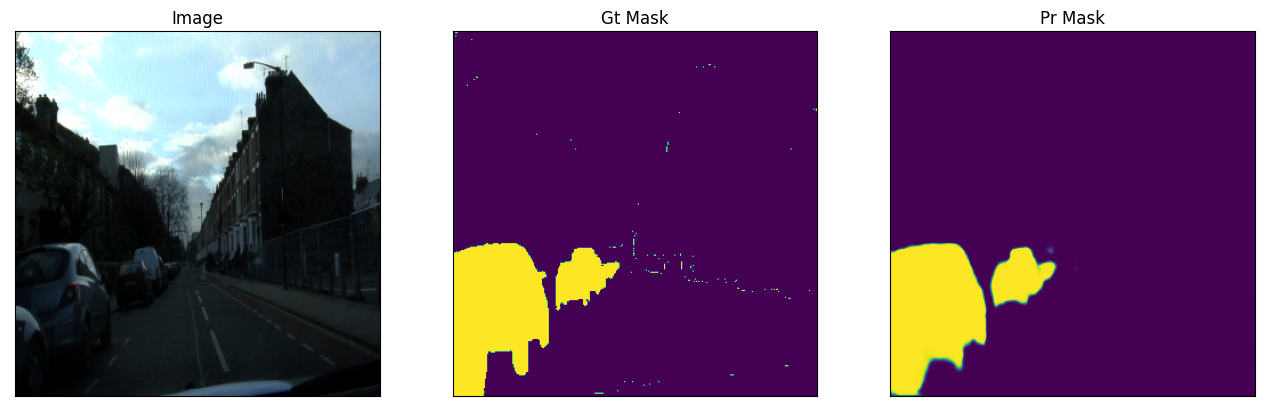

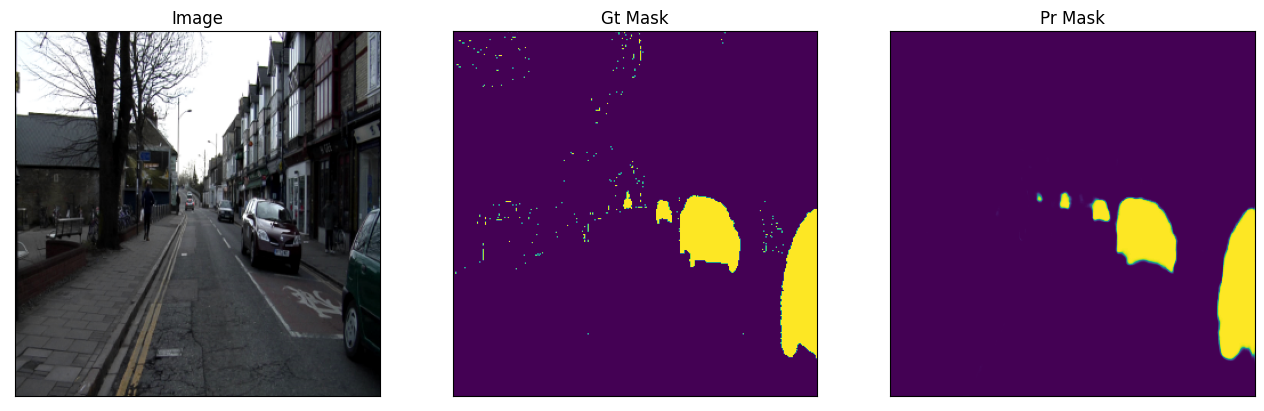

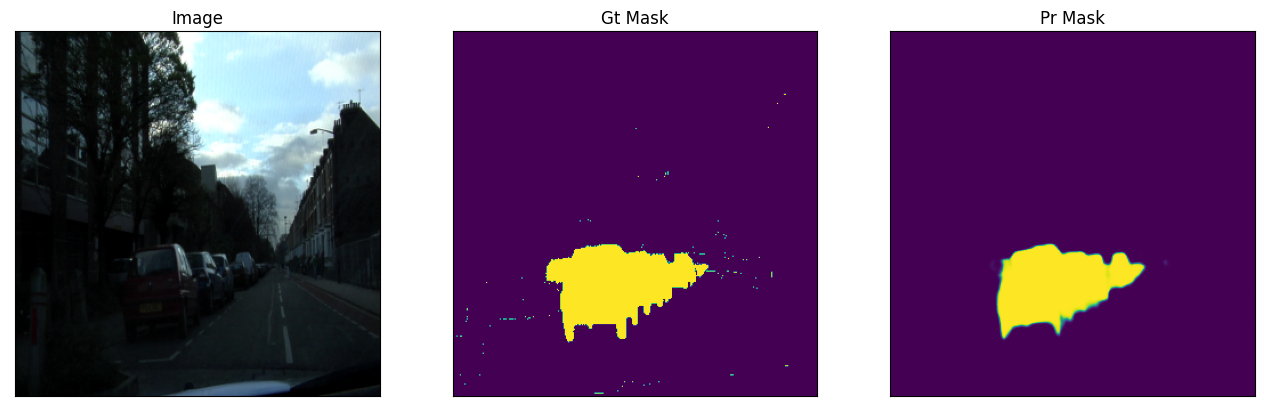

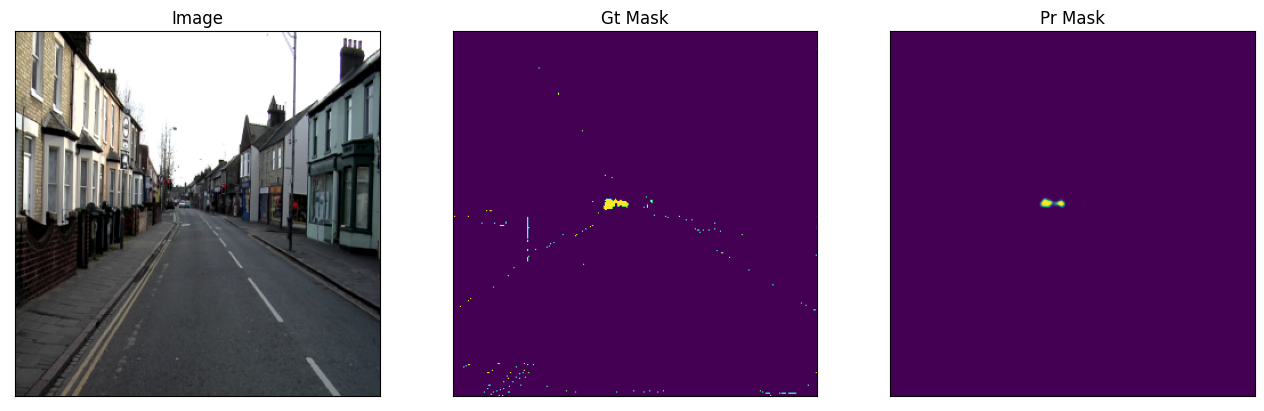

In [33]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,3].squeeze(),
        pr_mask=pr_mask[...,3].squeeze(),
    )